## IMDB Dataset Analysis

The Dataset of Imdb is analysed using apache spark and RDD(Resilent Distributed Dataset). There are two .tsv files.
1. Titles
2. Rating

The dataset is downloaded from: https://www.imdb.com/interfaces/

Titles: This tsv file contains all details related with the movies and is a massive dataset with 50M records.<br> Rating: This tsv file contains rating of some movies.

In [12]:
import pyspark as ps
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
from pyspark.sql import Row as row
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [13]:
conf=SparkConf().setAppName("Imdb data Analysis")
spark = SparkSession.builder.appName('Imdb').getOrCreate()

In [14]:
titles = sc.textFile('/home/prakass1/imdb_dataset/data_title.tsv').cache()
rating = sc.textFile('/home/prakass1/imdb_dataset/data_rating.tsv').cache()

In [15]:
def parse_data(line):
    data = line.split('\t')
    line = row(movieId = str(data[0]), movieType=str(data[1]), movieName = str(data[2]), genre = str(data[8]),runningTime=str(data[7]))
    return line

In [16]:
def parse_rating(line):
    data = line.split('\t')
    line = row(movieId = str(data[0]), avgRating=float(data[1]), votes = int(data[2]))
    return line

In [17]:
def filter_header(data):
    header = data.first()
    data = data.filter(lambda line: line !=header)
    return data

In [18]:
def parse_rating_data(line):
    data = line.split('\t')
    row = data[0] + "," + data[1] + "," + data[2]
    return row

In [19]:
def perform_title_mapping(lines):
    rows = lines.map(parse_data)
    return rows

In [20]:
def perform_rating_mapping(lines):
    rows = lines.map(parse_rating)
    return rows

In [21]:
#Filter the first header (Assumption made that header is always the first row)
titles_rows = filter_header(titles)
rating_rows = filter_header(rating)

In [22]:
#Perform mapping for the rows of data
titles = perform_title_mapping(titles_rows)
rating = perform_rating_mapping(rating_rows)

In [23]:
titles.take(2)

[Row(genre='Documentary,Short', movieId='tt0000001', movieName='Carmencita', movieType='short', runningTime='1'),
 Row(genre='Animation,Short', movieId='tt0000002', movieName='Le clown et ses chiens', movieType='short', runningTime='5')]

In [34]:
df_titles = spark.createDataFrame(titles)
df_rating = spark.createDataFrame(rating)

In [36]:
df_titles.describe().show()

+-------+-------+---------+------------+---------+------------------+
|summary|  genre|  movieId|   movieName|movieType|       runningTime|
+-------+-------+---------+------------+---------+------------------+
|  count|5040244|  5040244|     5040244|  5040244|           5040244|
|   mean|   null|     null|    Infinity|     null| 46.16335888245118|
| stddev|   null|     null|         NaN|     null|112.61739225073323|
|    min| Action|tt0000001|      !Next?|    movie|                 0|
|    max|     \N|tt8499476|Šiška Deluxe|videoGame|                \N|
+-------+-------+---------+------------+---------+------------------+



In [25]:
#Partition Both RDD
df_titles.head(5)

[Row(genre='Documentary,Short', movieId='tt0000001', movieName='Carmencita', movieType='short', runningTime='1'),
 Row(genre='Animation,Short', movieId='tt0000002', movieName='Le clown et ses chiens', movieType='short', runningTime='5'),
 Row(genre='Animation,Comedy,Romance', movieId='tt0000003', movieName='Pauvre Pierrot', movieType='short', runningTime='4'),
 Row(genre='Animation,Short', movieId='tt0000004', movieName='Un bon bock', movieType='short', runningTime='\\N'),
 Row(genre='Short', movieId='tt0000005', movieName='Blacksmith Scene', movieType='short', runningTime='1')]

In [26]:
#Describe the data of Titles
df_titles.printSchema()

root
 |-- genre: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- movieName: string (nullable = true)
 |-- movieType: string (nullable = true)
 |-- runningTime: string (nullable = true)



In [37]:
df_rating.head(5)

[Row(avgRating=5.8, movieId='tt0000001', votes=1382),
 Row(avgRating=6.5, movieId='tt0000002', votes=161),
 Row(avgRating=6.6, movieId='tt0000003', votes=960),
 Row(avgRating=6.4, movieId='tt0000004', votes=97),
 Row(avgRating=6.2, movieId='tt0000005', votes=1659)]

In [28]:
#Describe the data of Rating
df_rating.printSchema()

root
 |-- avgRating: double (nullable = true)
 |-- movieId: string (nullable = true)
 |-- votes: long (nullable = true)



In [17]:
df_rating.count()

838182

In [211]:
df_titles.count()

5040244

In [18]:
#Order the rating in the descending order of rating
grouped_data = df_rating.orderBy(desc('votes'))

In [45]:
#Only get type as movie
cachedTitles = df_titles.filter(df_titles.movieType=='movie').select('movieId','movieName','genre').cache()
#cachedTitles.count()
cachedTitles.movieId

Column<b'movieId'>

In [37]:
#Get only the top ten movies
topTenMovies= grouped_data.select('movieId','votes','avgRating').take(10)
topTenMovies

[Row(movieId='tt0111161', votes=1957480, avgRating=9.3),
 Row(movieId='tt0468569', votes=1929695, avgRating=9.0),
 Row(movieId='tt1375666', votes=1714048, avgRating=8.8),
 Row(movieId='tt0137523', votes=1569401, avgRating=8.8),
 Row(movieId='tt0110912', votes=1530948, avgRating=8.9),
 Row(movieId='tt0109830', votes=1486730, avgRating=8.8),
 Row(movieId='tt0120737', votes=1414976, avgRating=8.8),
 Row(movieId='tt0133093', votes=1407146, avgRating=8.7),
 Row(movieId='tt0167260', votes=1397414, avgRating=8.9),
 Row(movieId='tt0068646', votes=1340046, avgRating=9.2)]

In [38]:
votes=[]
for movie in topTenMovies:
    votes.append(movie[1])
votes

[1957480,
 1929695,
 1714048,
 1569401,
 1530948,
 1486730,
 1414976,
 1407146,
 1397414,
 1340046]

In [39]:
rating=[]
for movie in topTenMovies:
    rating.append(movie[2])
rating

[9.3, 9.0, 8.8, 8.8, 8.9, 8.8, 8.8, 8.7, 8.9, 9.2]

In [208]:
groupTitle = df_titles.orderBy('movieId')

In [23]:
#Collect all data for top ten movies
titles=[]
for movies in topTenMovies:
    titles.append(cachedTitles.filter((cachedTitles.movieId == movies[0])).collect())
titles

[[Row(movieId='tt0111161', movieName='The Shawshank Redemption', genre='Crime,Drama')],
 [Row(movieId='tt0468569', movieName='The Dark Knight', genre='Action,Crime,Drama')],
 [Row(movieId='tt1375666', movieName='Inception', genre='Action,Adventure,Sci-Fi')],
 [Row(movieId='tt0137523', movieName='Fight Club', genre='Drama')],
 [Row(movieId='tt0110912', movieName='Pulp Fiction', genre='Crime,Drama')],
 [Row(movieId='tt0109830', movieName='Forrest Gump', genre='Drama,Romance')],
 [Row(movieId='tt0120737', movieName='The Lord of the Rings: The Fellowship of the Ring', genre='Adventure,Drama,Fantasy')],
 [Row(movieId='tt0133093', movieName='The Matrix', genre='Action,Sci-Fi')],
 [Row(movieId='tt0167260', movieName='The Lord of the Rings: The Return of the King', genre='Adventure,Drama,Fantasy')],
 [Row(movieId='tt0068646', movieName='The Godfather', genre='Crime,Drama')]]

In [24]:
movieNames=[]
genre=[]
for movie in titles:
    movieNames.append(movie[0][1])
    genre.append(movie[0][2])

In [26]:
print(movieNames)

['The Shawshank Redemption', 'The Dark Knight', 'Inception', 'Fight Club', 'Pulp Fiction', 'Forrest Gump', 'The Lord of the Rings: The Fellowship of the Ring', 'The Matrix', 'The Lord of the Rings: The Return of the King', 'The Godfather']


In [27]:
print(genre)

['Crime,Drama', 'Action,Crime,Drama', 'Action,Adventure,Sci-Fi', 'Drama', 'Crime,Drama', 'Drama,Romance', 'Adventure,Drama,Fantasy', 'Action,Sci-Fi', 'Adventure,Drama,Fantasy', 'Crime,Drama']


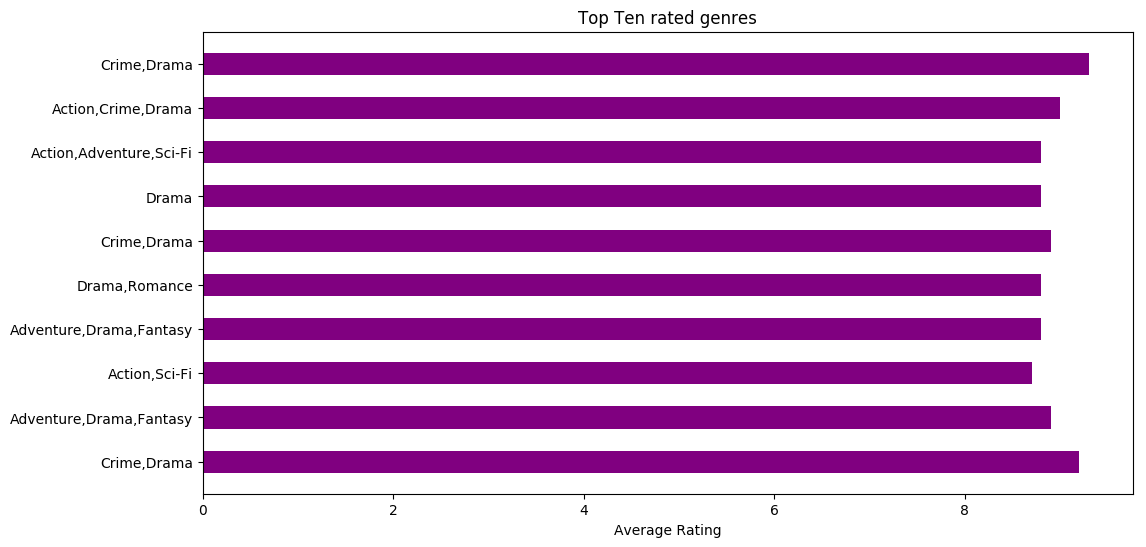

In [45]:
plt.rcdefaults()
fig,ax = plt.subplots(figsize=(12, 6))

# Example data
genres = genre
y_pos = np.arange(len(genres))
width = 0.5
ax.barh(y_pos, rating,width, align='center',
        color='purple')
ax.set_yticks(y_pos)
ax.set_yticklabels(genres)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Average Rating')
ax.set_title('Top Ten rated genres')

plt.show()

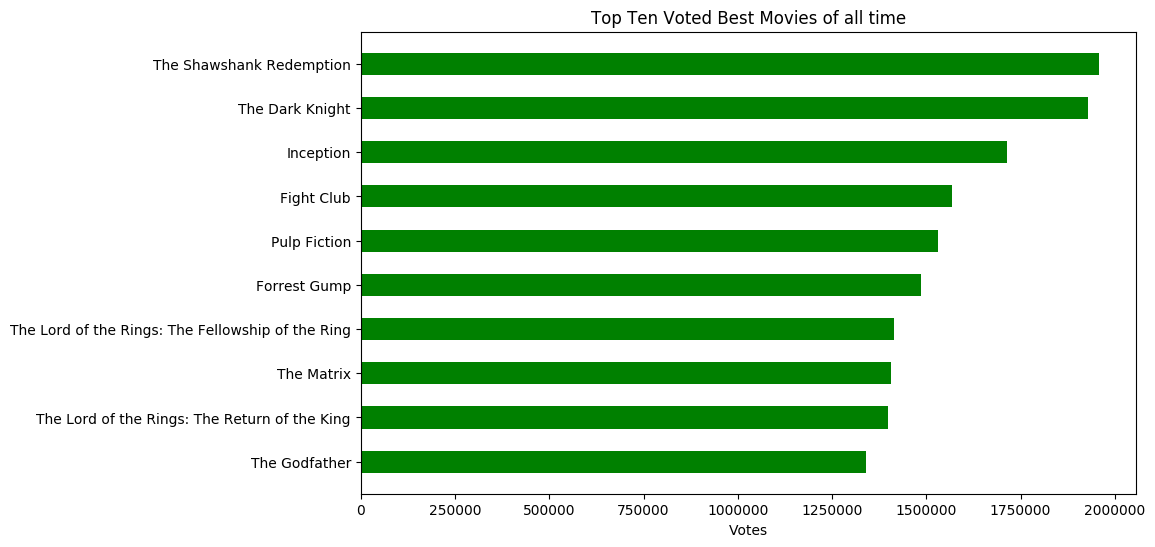

In [327]:
plt.rcdefaults()
fig,ax = plt.subplots(figsize=(10, 6))

# Example data
movies = movieNames
y_pos = np.arange(len(movies))
width = 0.5
ax.barh(y_pos, votes,width, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(movies)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Votes')
ax.set_title('Top Ten Voted Best Movies of all time')

plt.show()

In [46]:
#Get Count of Movies by Genre
genreMovieList=[]
genreMovieList.append(cachedTitles.filter(cachedTitles.genre.contains("Action")).collect())

genreMovieList

[[Row(movieId='tt0003545', movieName='Who Will Marry Mary?', genre='Action,Adventure'),
  Row(movieId='tt0003897', movieName='The Exploits of Elaine', genre='Action'),
  Row(movieId='tt0004052', movieName='The Hazards of Helen', genre='Action'),
  Row(movieId='tt0004223', movieName='The Life of General Villa', genre='Action,Adventure,Biography'),
  Row(movieId='tt0004272', movieName='Lucille Love: The Girl of Mystery', genre='Action'),
  Row(movieId='tt0004313', movieName='The Master Key', genre='Action,Adventure,Drama'),
  Row(movieId='tt0004465', movieName='The Perils of Pauline', genre='Action,Adventure,Drama'),
  Row(movieId='tt0004545', movieName='Rose of the Rancho', genre='Action,Adventure,Romance'),
  Row(movieId='tt0004635', movieName='The Squaw Man', genre='Action,Drama,Romance'),
  Row(movieId='tt0005073', movieName='The Chalice of Courage', genre='Action,Drama,Romance'),
  Row(movieId='tt0005389', movieName='The Girl and the Game', genre='Action'),
  Row(movieId='tt0005700'

In [1]:
print("The count of Action Movies are:" + str(len(genreMovieList[0])))

NameError: name 'genreMovieList' is not defined

## SECTION FOR MAKING PREDICTION ON TYPE OF THE MOVIE BY SEEING SOME FEATURES

In [54]:
dataset=[]
i=0
for i in int((df_titles.count())/1000):
    dataset.append(df_title.filter('runningTime','movieType').collect())
    i+=1

dataset

TypeError: 'int' object is not iterable

In [43]:
dataset = []
count=0
for movie in df_titles:
    if(count > 2000):
        break
    dataset.append(df_titles.filter(movie.runningTime + "," + movie.)
    count=count+1
dataset

[Column<b"genre['runningTime']">,
 Column<b"movieId['runningTime']">,
 Column<b"movieName['runningTime']">,
 Column<b"movieType['runningTime']">,
 Column<b"runningTime['runningTime']">]